# Custom Keras Generator
This notebook outlines how to build custom Keras generators. These are used to feed in more complex data into models with potentially complex processing, such as image augmentation. It also allows for multiple datasets to be fed into the model for training and validation.

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow

# Load entire dataset
X = np.linspace(0,100, 10000)
y = np.sin(X)

### Single Input/Output Dataset

In [28]:
def data_generator(X,y, batch_size = 64):
    
    """
    Overview
    --------
    Simple Keras data generating function.
    
    
    Inputs
    ------
    X (numpy.ndarray): NumPy array of training data, with number
        of samples in the first dimension.
    y (numpy.ndarray): NumPy array of target data, with number
        of samples in the first dimension.
    batch_size (int, optional): Batch size.
    
    
    Returns
    -------
    Subset of X and y of size batch_size.
    """
    
    X_length = len(X)
    
    while True:
        # Select files (paths/indices) for the batch
        batch_idx = np.random.randint(0, X_length, (batch_size))
        
        # Return a tuple of (input,output) to feed the network
        batch_x = np.array(X[batch_idx])
        batch_y = np.array(y[batch_idx])
        
        yield( batch_x, batch_y )

In [27]:
# Design model
model = Sequential()
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error')

In [25]:
model.fit_generator(image_generator(X, y, 32), steps_per_epoch = len(X)//64, epochs = 10)

Epoch 1/10
156/156 [==============================] - 2s 13ms/step - loss: 18.6917
Epoch 2/10
156/156 [==============================] - 2s 13ms/step - loss: 0.5521
Epoch 3/10
156/156 [==============================] - 2s 12ms/step - loss: 0.5546
Epoch 4/10
156/156 [==============================] - 2s 12ms/step - loss: 0.5482
Epoch 5/10
156/156 [==============================] - 2s 12ms/step - loss: 0.5512
Epoch 6/10
156/156 [==============================] - 2s 12ms/step - loss: 0.5452
Epoch 7/10
156/156 [==============================] - 2s 13ms/step - loss: 0.5406
Epoch 8/10
 87/156 [===============>..............] - ETA: 0s - loss: 0.5645

KeyboardInterrupt: 

In [32]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# This returns a tensor
inputs_main = Input(shape=(1,))
inputs_aux = Input(shape=(1,))

output_1_main = Dense(1, activation='relu')(inputs_main)
output_2_main = Dense(1, activation='relu')(output_1_main)

output_1_aux = Dense(1, activation='relu')(inputs_aux)
output_2_aux = Dense(1, activation='relu')(output_1_aux)

added = tensorflow.keras.layers.Add()([output_2_main, output_2_aux])

predictions = Dense(1)(added)

model = Model(inputs=[inputs_main, inputs_aux], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

model.fit_generator(multi_input_data_generator(X, y, 32), steps_per_epoch = len(X)//64, epochs = 5)

Epoch 1/10
156/156 [==============================] - 3s 22ms/step - loss: 331.6825
Epoch 2/10
156/156 [==============================] - 4s 24ms/step - loss: 67.1280
Epoch 3/10
156/156 [==============================] - 3s 22ms/step - loss: 8.0176
Epoch 4/10
156/156 [==============================] - 3s 22ms/step - loss: 0.7204
Epoch 5/10
156/156 [==============================] - 3s 22ms/step - loss: 0.5353
Epoch 6/10
156/156 [==============================] - 3s 22ms/step - loss: 0.5369
Epoch 7/10
156/156 [==============================] - 4s 28ms/step - loss: 0.5189
Epoch 8/10
156/156 [==============================] - 4s 25ms/step - loss: 0.5062
Epoch 9/10
156/156 [==============================] - 4s 24ms/step - loss: 0.5032
Epoch 10/10
156/156 [==============================] - 4s 23ms/step - loss: 0.5097


We assume that the data is in the format (time step, feature)

the data will be in the format (sample, time_step, feature) after processing.

In [139]:
class time_series_generator:
    
    """
    Generates batches of time series data suitable for Keras.
    
    Keras requires time series data to be fed in with the format 
    (batch_size, time_lags, features). This generator automatically
    reshapes tabular data. It also adds sinusoidal waves to give the
    neural net some concepts of where in the period we are located,
    as neural networks do not model periodicity very well.
    
    Handles multivariable inputs and outputs.
    """
    
    def __init__(self, X, y, lags, horizon, batch_size, period):
        
        "Initialise generator class."
        
        self.lags = lags
        self.horizon = horizon
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.period = period
        
        self.sin_period, self.cos_period = self.calc_sinusoidal_time(self.period)
        
    def calc_sinusoidal_time(self, period):
        
        """
        Encodes periodicity of the data into sinusoidal features.
        
        
        Inputs
        ------
        period (int): Periodicity of the data.
        
        
        Returns
        -------
        A pair of sine and cosine wave with periodicity equal to
            the passed value of period.
        """
        
        t = np.arange(len(self.X)) % period
        wave_arg = 2*np.pi*t/np.max(period)
        
        return np.sin(wave_arg), np.cos(wave_arg)
    
    def flow(self, X, y):
        
        """
        Generates a list of input data and target data.
        
        The input data list contains the reshaped time series data
        and another dataset containing sinusoidal features.
        """
        
        while True:
        
            input_batch_1 = []
            sinusoidal_batch = []
            targets_batch = []
    
            for i in range(self.batch_size):
                # Need to start indexing from lags
                data_idx = np.random.randint(self.lags, len(X) - self.horizon)
    
                data_lags = X[data_idx - lags: data_idx]
                input_batch_1.append(data_lags)
            
                targets = y[data_idx:data_idx + self.horizon]
                targets_batch.append(targets) 
        
                sinusoidal_feature = np.concatenate([self.sin_period[data_idx - self.lags: data_idx], 
                                                 self.cos_period[data_idx - self.lags: data_idx]])
            
                sinusoidal_batch.append(sinusoidal_feature)
            
            input_batch_1 = np.reshape(input_batch_1, (self.batch_size, self.lags, -1))
            sinusoidal_batch = np.reshape(sinusoidal_batch, (self.batch_size, self.lags * 2, -1))
            targets_batch = np.reshape(targets_batch, (self.batch_size, -1))
    
            yield [input_batch_1, sinusoidal_batch], targets_batch

In [181]:
lags = 12
horizon = 8
batch_size =  32
period = int(2*np.pi*100)
features = 1

# Generate data

X = np.linspace(0,10,1000).reshape((1000, -1))
print(np.shape(X))
y = np.sin(X) + np.random.normal(0,0.01, (1000,1))
print(np.shape(y))
y = y.reshape((1000,1))

data_gen = time_series_generator(X, y, lags, horizon, batch_size, period)

(1000, 1)
(1000, 1)


In [182]:
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

units = 64

# This returns a tensor
inputs_main = Input(shape=(lags,features))
inputs_aux = Input(shape=(lags * 2, 1))

output_1_main = Dense(units, activation='relu')(inputs_main)
output_2_main = Dense(units, activation='relu')(output_1_main)

output_1_aux = Dense(units, activation='relu')(inputs_aux)
output_2_aux = Dense(units, activation='relu')(output_1_aux)

concat = tensorflow.keras.layers.Concatenate(axis=1)([output_2_main, output_2_aux])

flatten = Flatten()(concat)
dense1 = Dense(units, activation='relu')(flatten)

predictions = Dense(horizon, activation = 'tanh')(dense1)

model = Model(inputs=[inputs_main, inputs_aux], outputs=predictions)

model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

model.fit_generator(data_gen.flow(X, y), steps_per_epoch = len(X)//64, epochs = 15)

Epoch 1/15
15/15 [==============================] - 1s 39ms/step - loss: 0.2752
Epoch 2/15
15/15 [==============================] - 1s 36ms/step - loss: 0.0369
Epoch 3/15
15/15 [==============================] - 1s 37ms/step - loss: 0.0205
Epoch 4/15
15/15 [==============================] - 1s 37ms/step - loss: 0.0129
Epoch 5/15
15/15 [==============================] - 1s 36ms/step - loss: 0.0104
Epoch 6/15
15/15 [==============================] - 1s 71ms/step - loss: 0.0081
Epoch 7/15
15/15 [==============================] - 1s 39ms/step - loss: 0.0059
Epoch 8/15
15/15 [==============================] - 1s 37ms/step - loss: 0.0044
Epoch 9/15
15/15 [==============================] - 1s 37ms/step - loss: 0.0040
Epoch 10/15
15/15 [==============================] - 1s 42ms/step - loss: 0.0031
Epoch 11/15
15/15 [==============================] - 1s 45ms/step - loss: 0.0028
Epoch 12/15
15/15 [==============================] - 1s 38ms/step - loss: 0.0023
Epoch 13/15
15/15 [==================

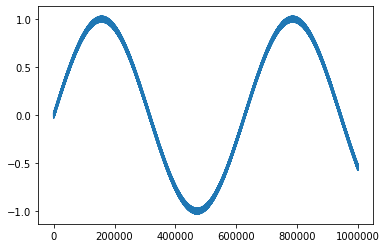

In [177]:
import matplotlib.pyplot as plt

plt.plot(y.reshape(-1))
plt.show()

In [188]:
result = model.predict_generator(data_gen.flow(X, y), steps = 1)

In [190]:
model.predict(X[:12].reshape(1,-1,1))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[0.        ],
        [0.01001001],
        [0.02002002],
        [0.03003003],
        [0.04004004],
        [0.05005005],
        [0.06006006],
        [0.07007007],
        [0.08008008],
 ...